## Example: photonic crystal cavity

See on [github](https://github.com/flexcompute/tidy3d-notebooks/blob/main/L3_cavity.ipynb), run on [colab](https://colab.research.google.com/github/flexcompute/tidy3d-notebooks/blob/main/L3_cavity.ipynb), or just follow along with the output below.

In this notebook, we will simulate the commonly used L3 photonic crystal cavity composed of three missing holes in a hexagonal lattice of holes in a silicon slab. 

In [1]:
# basic ipython configuration (reload source code automatically and plots inline)
%load_ext autoreload
%autoreload 2
%matplotlib inline

# standard python imports
import numpy as np
import matplotlib.pyplot as plt

# get the most recent version of tidy3d
!pip install -q --upgrade tidy3d

# tidy3D import
import tidy3d as td
from tidy3d import web

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Coarse simulation

We will first run a broadband simulation to examine the spectrum, and zone in on the fundamental mode of the cavity. We start with defining some general parameters. We will use a fairly low spatial resolution for this initaly simulation. It's worth remembering that the PML extend **beyond** the simulation domain, so we don't need to worry about them covering some of the PhC holes. The one thing we have to remember is to extend the slab through the PML.

In [2]:
# Number of PhC periods in x and y directions
Nx, Ny = 16, 12

# Lattice constant of the PhC in micron
alattice = 0.4

# Regular PhC lattice parameters
ra = 0.25 * alattice # hole radius
d_slab = 0.22        # slab thickness
n_slab = 3.48        # refractive index of the slab

# Materials - air and silicon
air = td.Medium(epsilon=1)
si = td.Medium(epsilon=n_slab**2)

# Mesh step in x, y, z, in micron
dl = 0.04
mesh_step = [dl, dl*np.sqrt(3)/2, dl]

# Central frequency around which we'll look for the cavity mode (Hz)
fcen = 2e14
# Source bandwidth (Hz)
fwidth = 4e13

# Simulation run time (s)
run_time = 20/fwidth

# Number of PML layers to use along each of the three directions
npml = 15
pml_layers = npml*np.ones((3,))

# Simulation domain size (micron)
sim_size = [(Nx+2)*alattice,
            ((Ny+1)*alattice)*np.sqrt(3)/2,
            4]

Next, we define the positions of the holes that make the photonic crystal structure.

In [3]:
# Define x and y positions in one quadrant of the simulation domain
xp, yp = [], []
nx, ny = Nx//2 + 1, Ny//2 + 1
for iy in range(ny):
    for ix in range(nx):
        xp.append(ix + (iy%2)*0.5)
        yp.append(iy*np.sqrt(3)/2)

# Remove the first two holes to make the L3 defect
xp = xp[2:]
yp = yp[2:]

# Append holes for the other three quadrants
xf, yf = [], []
for x, y in zip(xp, yp):
    xf += [x, x, -x]
    yf += [y, -y, y]
    if x > 0 and y > 0:
        xf += [-x]
        yf += [-y]

Initialize all structures.

In [4]:
slab = td.Box(center=[0, 0, 0], size=[td.inf, td.inf, d_slab], material=si)

holes = []
for x, y in zip(xf, yf):
    holes.append(
        td.Cylinder(
            center = np.array([x, y, 0])*alattice,
            axis = 'z',
            radius = ra,
            height = d_slab,
            material = air))

Initialize the source. We are looking for the fundamental mode of the L3 cavity, so we use a y-polarized  source at the center of the cavity.

In [5]:
source = td.PointDipole(
    center=[0, 0, 0],
    source_time=td.GaussianPulse(
        frequency=fcen,
        fwidth=fwidth),
    component='Ey')

Initialize the simulation and visualize the structure and the source.

Initializing simulation...
Mesh step (micron): [4.00e-02, 3.46e-02, 4.00e-02].
Simulation domain in number of grid points: [210, 160, 130].
Total number of grid points: 4.37e+06.
Total number of time steps: 7602.


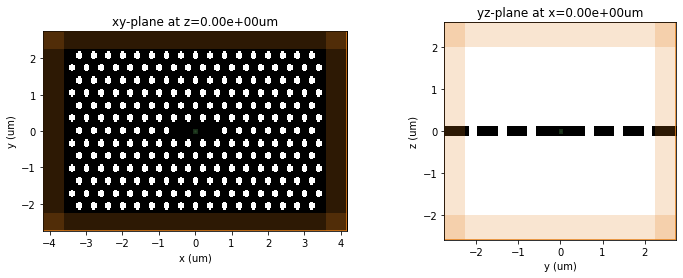

In [6]:
sim = td.Simulation(
    size=sim_size, 
    mesh_step=mesh_step, 
    structures=[slab]+holes, 
    sources=[source],
    run_time=run_time,
    pml_layers=pml_layers)
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sim.viz_eps_2D(normal='z', ax=ax[0]);
sim.viz_eps_2D(normal='x', ax=ax[1]);

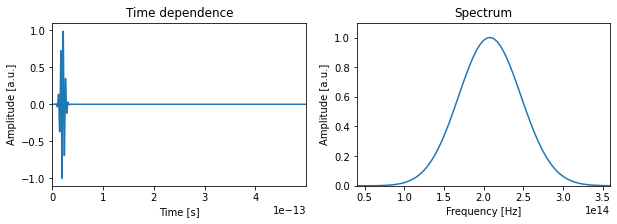

In [7]:
sim.viz_source(source)
plt.show()

Finally, we also place a time monitor in the same location as the source. We set the time monitor starting time to be after the source decay, such that we can exclude the source signature from the recorded spectrum.

In [8]:
t_start = 1e-13
tmonitor = td.TimeMonitor(center=[0, 0, 0], size=[0, 0, 0], t_start=t_start)

# To add the monitor to the simulation, we can just re-initialize it.
sim = td.Simulation(
    size=sim_size, 
    mesh_step=mesh_step, 
    structures=[slab]+holes, 
    sources=[source],
    monitors=[tmonitor],
    run_time=run_time,
    pml_layers=pml_layers)

Initializing simulation...
Mesh step (micron): [4.00e-02, 3.46e-02, 4.00e-02].
Simulation domain in number of grid points: [210, 160, 130].
Total number of grid points: 4.37e+06.
Total number of time steps: 7602.
Estimated data size (GB) of monitor monitor: 0.0001.


### Run simulation and examine the spectrum

Now that the simulation is constructed, we can run it using the `web` API of Tidy3D. First, we submit the project.

In [9]:
# Submit a project to the cluster
project = web.new_project(sim.export(), task_name='L3 low res')

Uploading the json file...


And we can continuously monitor the status until the run is succsessful.

In [10]:
web.monitor_project(project['taskId'])

Project 'L3 low res-34' status: success...                                



Once the run is successful, we can download the results and load them in the simulation object.

In [11]:
web.download_results(project['taskId'], target_folder='out')
sim.load_results('out/monitor_data.hdf5')

file download progress: 100.00 %Applying source normalization to all frequency monitors using source index 0.


We finally plot the time dependence of the field in the center of the cavity, and the spectrum computed using a Fourier transform of that field. For the latter, we use the in-built `dft_spectrum` function.

Text(0.5, 1.0, 'Spectrum')

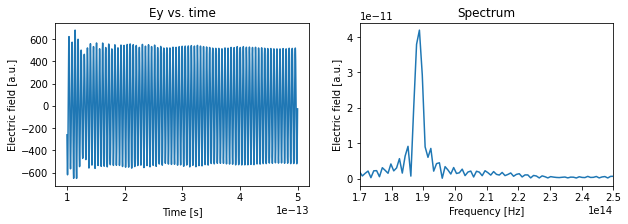

In [12]:
# Get data from the TimeMonitor
tdata = sim.data(tmonitor)
tmesh = tdata["tmesh"]
Nt = tmesh.size
Ey = tdata['E'][1, 0, 0, 0, :]

fig, ax = plt.subplots(1, 2, figsize=(10, 3))

# Plot time dependence 
ax[0].plot(tmesh, Ey)
ax[0].set_xlabel("Time [s]")
ax[0].set_ylabel("Electric field [a.u.]");
ax[0].set_title("Ey vs. time")

# Make frequency mesh and plot spectrum
dt = tmesh[1] - tmesh[0]
fmesh = np.linspace(1.6e14, 2.5e14, 101)

ax[1].plot(fmesh, np.abs(td.dft_spectrum(Ey, dt, fmesh)))
ax[1].set_xlim(1.7e14, 2.5e14)
ax[1].set_xlabel("Frequency [Hz]")
ax[1].set_ylabel("Electric field [a.u.]");
ax[1].set_title("Spectrum");

We see a big peak close to `f = 190THz`, which is most likely what we are looking for, because a) the fundamental mode is the longest-lived and b) we use a y-polarized source at the center of the simulation domain, which does not excite some of the other modes. Next, we refine the simulation and compute the field profile of this fundamental mode.

### Refine simulation, use symmetries, get mode profile

Now that we've seen a clear resonant peak, we can increase the resolution of the simulation to obtain more accurate results, and to get a high-resolution image of the cavity mode. We will also demonstrate how to use reflection symmetries. We center the source frequency close to the peak of the spectrum above, and decrease the bandwidth to exclude any other modes. We will also double the spatial resolution, making it 20 pixels per lattice period.

In [13]:
# New target frequency based on spectrum above
fcen = 1.90e14

# Narrow-bandwidth source
source = td.PointDipole(
    center=[0, 0, 0],
    source_time=td.GaussianPulse(
        frequency=fcen,
        fwidth=fwidth/5),
    component='Ey')

# Also increase the run time a bit
run_time = 50/fwidth

# 20 pixels per lattice period
dl = 0.02
mesh_step = [dl, dl*np.sqrt(3)/2, dl]

We can use both a time and a frequency monitor to obtain the field profile, each coming with advantages and disadvantages. The frequency monitor captures accurately the frequency-domain field, but that includes the source signature. On the other hand, examining the time-domain field can capture the "eigenmode" of the system, but only if all the other modes have decayed. This is, to a very large extent, the case in our simulation, so as we'll see the second approach works very well.

**NB**: An important thing to note is that a 2D time monitor can result in a very large amount of data. Because of this, we will only record the field at the last time step, setting `t_start = run_time` in the time monitor.

In [14]:
# Time and frequency monitors
tmonitor = td.TimeMonitor(
    center=[0, 0, 0],
    size=[4, 2*np.sqrt(3), 0],
    t_start=run_time)
fmonitor = td.FreqMonitor(
    center=[0, 0, 0],
    size=[4, 2*np.sqrt(3), 0],
    freqs=fcen)

Finally, we initialize the simulation, and also define reflection symmetries with respect to the x-, y-, and z-planes. Note that the eigenvalue of the symmetry (plus or minus one) has to be carefully determined, taking into account the vectorial nature of the electric field (and the pseudo-vector nature of the magnetic field). As an extra hint, positive symmetry is equivalent to a PMC plane, where the *normal* E-field component vanishes, while negative symmetry is equivalent to a PEC plane, where the *parallel* components of the E-field vanish. This is also the reason why in the visualization, we use blue and red to denote these symmetries, which are the same colors used for structures made of PMC and PEC material, respectively.

Initializing simulation...
Mesh step (micron): [2.00e-02, 1.73e-02, 2.00e-02].
Simulation domain in number of grid points: [390, 290, 230].
Computation domain (after symmetries): [197, 145, 117].
Total number of grid points: 3.34e+06.
Total number of time steps: 38010.
Estimated data size (GB) of monitor monitor: 0.0002.
Estimated data size (GB) of monitor monitor_1: 0.0005.


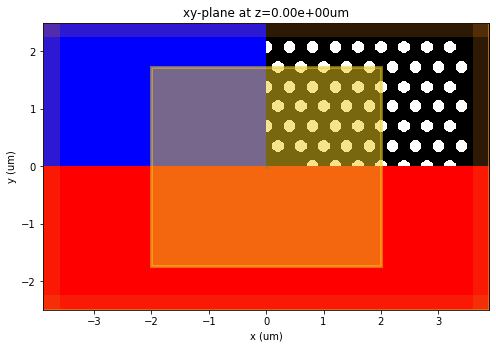

In [15]:
# Initialize simulation
sim = td.Simulation(
    size=sim_size, 
    mesh_step=mesh_step, 
    structures=[slab]+holes, 
    sources=[source], 
    monitors=[tmonitor, fmonitor],
    run_time=run_time,
    pml_layers=pml_layers,
    symmetries=[1, -1, 1])
fig, ax = plt.subplots(1, figsize=(8, 6))
sim.viz_eps_2D(normal='z', ax=ax);

We run the simulation as above.

In [16]:
project = web.new_project(sim.export(), task_name='L3 high res')

Uploading the json file...


In [17]:
web.monitor_project(project['taskId'])

Project 'L3 high res-28' status: success...                                



In [18]:
web.download_results(project['taskId'], target_folder='out')
sim.load_results('out/monitor_data.hdf5')

file download progress: 100.00 %Applying source normalization to all frequency monitors using source index 0.


Finally, we plot the field recorded by the frequency monitor, with a rescaled colorbar in order to suppress the strongly dominant feature of the source in the center. On the other hand, the field stored in the time monitor reveals the eigenmode of the cavity.

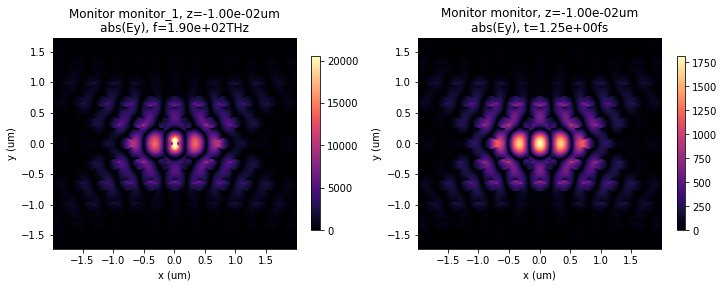

In [19]:
monitors = sim.monitors
E_dft = sim.data(monitors[1])['E'][1, :, :, :, :]
E_dft_max = np.amax(np.abs(E_dft))
dft_clim = (0, E_dft_max/4)
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sim.viz_field_2D(monitors[1], eps_alpha=0, comp='y', val='abs', cbar=True, ax=ax[0], clim=dft_clim)
sim.viz_field_2D(monitors[0], eps_alpha=0, comp='y', val='abs', cbar=True, ax=ax[1]);